In [ ]:
!pip install torch torchvision numpy pandas

## Dataset ##

In [1]:
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision as tv

/home/vishu/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = tv.transforms.Compose([
    tv.transforms.CenterCrop(size=(128,128)),
    tv.transforms.ToTensor()
])

In [3]:
train_ds = datasets.CelebA('data',
                           split='train',
                           transform=transform,
                           download=False)

In [4]:
train_loader = DataLoader(dataset=train_ds,
                          batch_size=32,
                          num_workers=2)

In [5]:
import matplotlib.pyplot as plt

tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1])


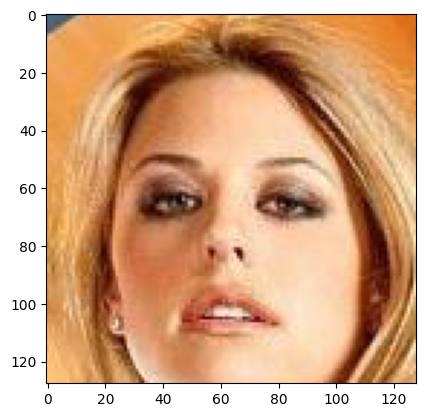

In [6]:
for x,l in train_loader:
    image_tensor = x[23,:,:,:]
    image_tensor = image_tensor.permute(1,2,0).detach().cpu().numpy()
    plt.imshow(image_tensor)
    print(l[23])
    break

In [7]:
"""Targets are 40-dim vectors representing
00 - 5_o_Clock_Shadow
01 - Arched_Eyebrows
02 - Attractive 
03 - Bags_Under_Eyes
04 - Bald
05 - Bangs
06 - Big_Lips
07 - Big_Nose
08 - Black_Hair
09 - Blond_Hair
10 - Blurry 
11 - Brown_Hair 
12 - Bushy_Eyebrows 
13 - Chubby 
14 - Double_Chin 
15 - Eyeglasses 
16 - Goatee 
17 - Gray_Hair 
18 - Heavy_Makeup 
19 - High_Cheekbones 
20 - Male 
21 - Mouth_Slightly_Open 
22 - Mustache 
23 - Narrow_Eyes 
24 - No_Beard 
25 - Oval_Face 
26 - Pale_Skin 
27 - Pointy_Nose 
28 - Receding_Hairline 
29 - Rosy_Cheeks 
30 - Sideburns 
31 - Smiling 
32 - Straight_Hair 
33 - Wavy_Hair 
34 - Wearing_Earrings 
35 - Wearing_Hat 
36 - Wearing_Lipstick 
37 - Wearing_Necklace 
38 - Wearing_Necktie 
39 - Young         
"""

'Targets are 40-dim vectors representing\n00 - 5_o_Clock_Shadow\n01 - Arched_Eyebrows\n02 - Attractive \n03 - Bags_Under_Eyes\n04 - Bald\n05 - Bangs\n06 - Big_Lips\n07 - Big_Nose\n08 - Black_Hair\n09 - Blond_Hair\n10 - Blurry \n11 - Brown_Hair \n12 - Bushy_Eyebrows \n13 - Chubby \n14 - Double_Chin \n15 - Eyeglasses \n16 - Goatee \n17 - Gray_Hair \n18 - Heavy_Makeup \n19 - High_Cheekbones \n20 - Male \n21 - Mouth_Slightly_Open \n22 - Mustache \n23 - Narrow_Eyes \n24 - No_Beard \n25 - Oval_Face \n26 - Pale_Skin \n27 - Pointy_Nose \n28 - Receding_Hairline \n29 - Rosy_Cheeks \n30 - Sideburns \n31 - Smiling \n32 - Straight_Hair \n33 - Wavy_Hair \n34 - Wearing_Earrings \n35 - Wearing_Hat \n36 - Wearing_Lipstick \n37 - Wearing_Necklace \n38 - Wearing_Necktie \n39 - Young         \n'

## VAE ##

In [8]:
import torch.nn as nn
import torch

In [9]:
class Reshape(nn.Module):
    def __init__(self,*size):
        super().__init__()
        self.size = size

    def forward(self,x):
        return x.view(self.size)
    
class Trim(nn.Module):
    def __init__(self,*arg):
        super().__init__()

    def forward(self,x):
        #X-> 32,3,129,129
        return x[:,:,:128,:128]

In [32]:
class VAE(nn.Module):
   
    
    def __init__(self):
        #initial image -> 32,3,128,128
        super(VAE,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,stride=2,kernel_size=3,padding=1), # 32,32,64,64
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.001),
            nn.Dropout2d(0.2),

            nn.Conv2d(in_channels=32,out_channels=64,stride=2,kernel_size=3,padding=1), # 32,64,32,32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.001),
            nn.Dropout2d(0.2),

            nn.Conv2d(in_channels=64,out_channels=64,stride=2,kernel_size=3,padding=1), # 32,64,16,16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.001),
            nn.Dropout2d(0.2),

            nn.Conv2d(in_channels=64,out_channels=64,stride=2,kernel_size=3,padding=1), # 32,64,8,8 -> 32,4096
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.001),
            nn.Dropout2d(0.2),

            nn.Flatten(start_dim=1,end_dim=-1)

        )

        self.decoder = nn.Sequential(
            #32,200 -> store usefull information
            nn.Linear(200,4096),#-> 64,8,8
            Reshape(-1,64,8,8),#32,64,8,8

            nn.ConvTranspose2d(in_channels=64,out_channels=64,stride=2,kernel_size=3), # 32,64,8,8 -> 32,64,16,16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.001),
            nn.Dropout2d(0.2),

            nn.ConvTranspose2d(in_channels=64,out_channels=64,stride=2,kernel_size=3,padding=1), # 32,64,16,16 -> 32,64,32,32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.001),
            nn.Dropout2d(0.2),

            nn.ConvTranspose2d(in_channels=64,out_channels=32,stride=2,kernel_size=3,padding=1), # 32,64,32,32 -> 32,32,64,64
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.001),
            nn.Dropout2d(0.2),

            nn.ConvTranspose2d(in_channels=32,out_channels=3,stride=2,kernel_size=3,padding=1), # 32,32,64,64 -> 32,3,129,129 -> 32,3,128,128
    
            Trim()  #32,3,129,129 -> 32,3,128,128
        
        )

        self.mean = nn.Linear(4096,200)
        self.varience = nn.Linear(4096,200)



    def repearam(self,mean,std):
        eps = torch.randn(mean.size(0),mean.size(1)) # Gaussian or normal distrbution 32,200
        z = mean + torch.exp(std/2) * eps #Z - > sampled value from a gaussian or normal dist
        return z # 32,200
    

    def forward(self,X):
        #X - > 32,3,128,128
        X = self.encoder(X)
        mean = self.mean(X) # 32,200
        std = self.varience(X) #32,200
        z = self.repearam(mean=mean,std=std)
        img = self.decoder(z) # 32,3,128,128
        return img,mean,std
        


        

In [33]:
model = VAE()

In [34]:
model = torch.load('VAE.pt',map_location=torch.device('cpu'))

In [35]:
model.parameters()

<generator object Module.parameters at 0x7f02e6d9e9d0>

In [16]:
unnormalizer = None

In [54]:
BATCH_SIZE = 32
LR = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=LR)
train_loss = []
EPOCH = 20

## Result ##

In [49]:
import numpy as np

In [52]:
model = torch.load('VAE.pt',map_location=torch.device('cpu'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


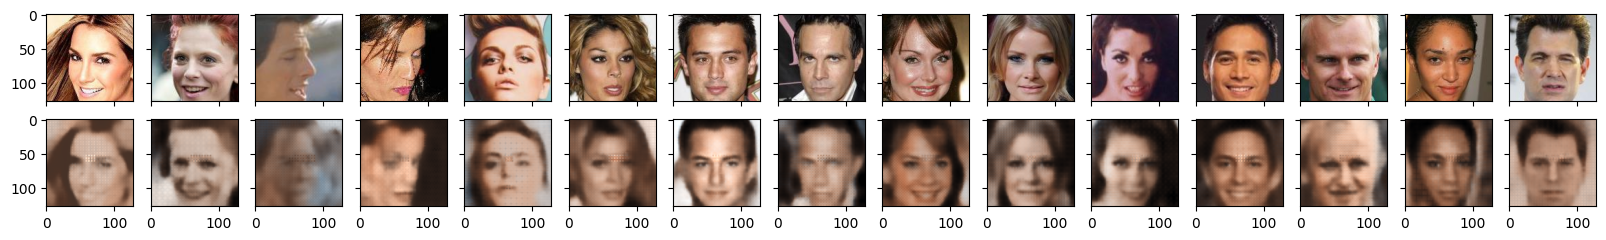

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=15, 
                             sharex=True, sharey=True, figsize=(20,2.5))
for batch,(features,_) in enumerate(train_loader):
      
        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            decoded_images,z_mean, z_log_var  = model.forward(features)
            #decoded-image-> reconstructed image 


        orig_images = features
        break

for i in range(15):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))        
        if color_channels > 1:
            curr_img = np.transpose(curr_img, (1, 2, 0))
            ax[i].imshow(curr_img)


In [68]:
cc = torch.randn(32,3,128,128)

In [69]:
decoded_images,z_mean, z_log_var  = model.forward(cc)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


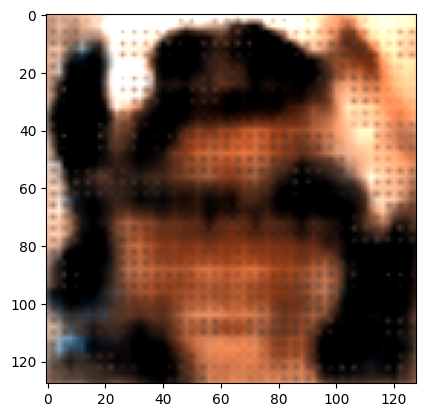

In [72]:
ft = decoded_images[2].detach().cpu().numpy()
ft = np.transpose(ft,(1,2,0))
plt.imshow(ft)